In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import matplotlib.pyplot as plt
import os
import scipy.stats, random
from scipy.interpolate import interp1d

The purpose of this notebook is to run a nano-simulation to test how well the method of using YSQ forecast data for initialization only will replicate the forecast estimates of YSQ into the future

In [20]:
filepath = '/ihme/csu/swiss_re/forecast/'

# just look at single demographic group for now
location = 'Zhejiang'
age_group = ['50 to 54','55 to 59','60 to 64']
sex = 'Male'
year = list(range(2020,2031))

In [21]:
# import exposure forecst data
prevalence = pd.read_csv(filepath + 'prev_forecast_bounds.csv')
ysq = pd.read_csv(filepath + 'ysq_forecast_bounds.csv')

In [22]:
prev_data = (prevalence.loc[prevalence.sex_id == sex].loc[prevalence.year_id.isin(year)]
             .loc[prevalence.location_id == location].loc[prevalence.age_group_id.isin(age_group)])
current_prev = prev_data.loc[prev_data.measure == 'current']
former_prev = prev_data.loc[prev_data.measure == 'former']

In [23]:
ysq_data = (ysq.loc[ysq.sex_id == sex].loc[ysq.year_id == 2020]
             .loc[ysq.location_id == location].loc[ysq.age_group_id.isin(age_group)])

In [24]:
n_simulants = 100_000
sims = pd.DataFrame()
sims['age'] = np.random.choice(list(range(50,60)),n_simulants,p=[1/len(list(range(50,60)))]*len(list(range(50,60))))
sims['age_group'] = np.where(sims.age<55,'50 to 54',np.where(sims.age<60,'55 to 59','60 to 64'))
sims['propensity'] = np.random.uniform(0,1,n_simulants)
sims['smok_2020'] = np.where(sims.age_group == '50 to 54', 
                             np.where(sims.propensity < 1 - current_prev.loc[current_prev.age_group_id=='50 to 54'].loc[current_prev.year_id == 2020]['median'].values[0] - former_prev.loc[former_prev.age_group_id=='50 to 54'].loc[former_prev.year_id == 2020]['median'].values[0],
                             'never',
                             np.where(sims.propensity < 1 - former_prev.loc[former_prev.age_group_id=='50 to 54'].loc[former_prev.year_id == 2020]['median'].values[0], 
                                     'current','former')),
                             np.where(sims.propensity < 1 - current_prev.loc[current_prev.age_group_id=='55 to 59'].loc[current_prev.year_id == 2020]['median'].values[0] - former_prev.loc[former_prev.age_group_id=='55 to 59'].loc[former_prev.year_id == 2020]['median'].values[0],
                             'never',
                             np.where(sims.propensity < 1 - former_prev.loc[former_prev.age_group_id=='55 to 59'].loc[former_prev.year_id == 2020]['median'].values[0], 
                                     'current','former')))
sims['ysq_bin_2020'] = np.where(sims.age_group=='50 to 54', np.random.choice(ysq_data.loc[ysq_data.age_group_id=='50 to 54']['bin'].values,
                                        n_simulants, p=ysq_data.loc[ysq_data.age_group_id=='50 to 54']['median'].values/ysq_data.loc[ysq_data.age_group_id=='50 to 54']['median'].sum()),
                                np.random.choice(ysq_data.loc[ysq_data.age_group_id=='55 to 59']['bin'].values,
                                        n_simulants, p=ysq_data.loc[ysq_data.age_group_id=='55 to 59']['median'].values/ysq_data.loc[ysq_data.age_group_id=='55 to 59']['median'].sum()))
sims['ysq_2020_min'] = sims['ysq_bin_2020'].str.split(' ', n=2, expand=True)[0].astype(int)
sims['ysq_2020_max'] = sims['ysq_bin_2020'].str.split(' ', n=2, expand=True)[2].astype(int)
sims['ysq_2020'] = np.random.uniform(sims.ysq_2020_min,sims.ysq_2020_max)
sims.head()

,age,age_group,propensity,smok_2020,ysq_bin_2020,ysq_2020_min,ysq_2020_max,ysq_2020
0,55,55 to 59,0.687335,current,20 to 29,20,29,22.025667
1,54,50 to 54,0.691642,current,10 to 19,10,19,16.820231
2,52,50 to 54,0.938769,former,20 to 29,20,29,26.469108
3,55,55 to 59,0.859026,former,10 to 19,10,19,17.768548
4,58,55 to 59,0.688666,current,10 to 19,10,19,17.731860


In [25]:
# step ahead
for i in list(range(2021,2031)):
    sims['age'] = sims['age'] + 1
    sims[f'age_group_{i}'] = np.where(sims.age<55,'50 to 54',np.where(sims.age<60,'55 to 59','60 to 64'))
    sims[f'smok_{i}'] = np.where(sims.age_group == '50 to 54', 
                             np.where(sims.propensity < 1 - current_prev.loc[current_prev.age_group_id=='50 to 54'].loc[current_prev.year_id == i]['median'].values[0] - former_prev.loc[former_prev.age_group_id=='50 to 54'].loc[former_prev.year_id == i]['median'].values[0],
                             'never',
                             np.where(sims.propensity < 1 - former_prev.loc[former_prev.age_group_id=='50 to 54'].loc[former_prev.year_id == i]['median'].values[0], 
                                     'current','former')),
                             np.where(sims.age_group == '55 to 54',
                                      np.where(sims.propensity < 1 - current_prev.loc[current_prev.age_group_id=='55 to 59'].loc[current_prev.year_id == i]['median'].values[0] - former_prev.loc[former_prev.age_group_id=='55 to 59'].loc[former_prev.year_id == i]['median'].values[0],
                                     'never',
                                     np.where(sims.propensity < 1 - former_prev.loc[former_prev.age_group_id=='55 to 59'].loc[former_prev.year_id == i]['median'].values[0], 
                                             'current','former')),
                                      np.where(sims.propensity < 1 - current_prev.loc[current_prev.age_group_id=='60 to 64'].loc[current_prev.year_id == i]['median'].values[0] - former_prev.loc[former_prev.age_group_id=='60 to 64'].loc[former_prev.year_id == i]['median'].values[0],
                                     'never',
                                     np.where(sims.propensity < 1 - former_prev.loc[former_prev.age_group_id=='60 to 64'].loc[former_prev.year_id == i]['median'].values[0], 
                                             'current','former'))))
    sims.loc[(sims[f'smok_{i-1}'] == 'former') & (sims[f'smok_{i}'] == 'former'), f'ysq_{i}'] = sims[f'ysq_{i-1}'] + 1
    sims.loc[(sims[f'smok_{i-1}'] != 'former') & (sims[f'smok_{i}'] == 'former'), f'ysq_{i}'] = 0
    sims.loc[(sims[f'smok_{i}'] != 'former'), f'ysq_{i}'] = np.nan
sims.head()

,age,age_group,propensity,smok_2020,ysq_bin_2020,ysq_2020_min,ysq_2020_max,ysq_2020,age_group_2021,smok_2021,...,ysq_2027,age_group_2028,smok_2028,ysq_2028,age_group_2029,smok_2029,ysq_2029,age_group_2030,smok_2030,ysq_2030
0,65,55 to 59,0.687335,current,20 to 29,20,29,22.025667,55 to 59,current,...,NaN,60 to 64,current,NaN,60 to 64,current,NaN,60 to 64,current,NaN
1,64,50 to 54,0.691642,current,10 to 19,10,19,16.820231,55 to 59,current,...,NaN,60 to 64,current,NaN,60 to 64,current,NaN,60 to 64,current,NaN
2,62,50 to 54,0.938769,former,20 to 29,20,29,26.469108,50 to 54,former,...,33.469108,60 to 64,former,34.469108,60 to 64,former,35.469108,60 to 64,former,36.469108
3,65,55 to 59,0.859026,former,10 to 19,10,19,17.768548,55 to 59,former,...,24.768548,60 to 64,former,25.768548,60 to 64,former,26.768548,60 to 64,former,27.768548
4,68,55 to 59,0.688666,current,10 to 19,10,19,17.731860,55 to 59,current,...,NaN,60 to 64,current,NaN,60 to 64,current,NaN,60 to 64,current,NaN


In [27]:
counts = []
for i in list(range(2021,2031)):
    counts.append(len(sims.loc[(sims[f'smok_{i-1}'] != 'former') & (sims[f'smok_{i}'] == 'former')]))
counts

[1508, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Text(0, 0.5, 'Density')

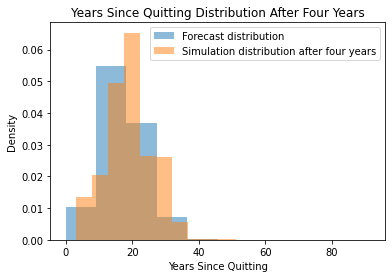

In [8]:
former_smokers = sims.loc[sims.smok_2024 == 'former'].loc[sims.age_group_2024=='55 to 59']

ysq_2024 = (ysq.loc[ysq.sex_id == sex].loc[ysq.year_id == 2024]
             .loc[ysq.location_id == location].loc[ysq.age_group_id=='55 to 59'])
sims_val = pd.DataFrame()
sims_val['2024_ysq'] = np.random.choice(ysq_2024.bin.values,
                                        n_simulants, p=ysq_2024['median'].values / (ysq_2024['median'].sum()))
sims_val['val_2024'] = sims_val['2024_ysq'].str.split(' ', n=2, expand=True)[0].astype(int)
sims_val['val_2024_max'] = sims_val['2024_ysq'].str.split(' ', n=2, expand=True)[2].astype(int)
sims_val['val_2024_uniform'] = np.random.uniform(sims_val.val_2024, sims_val.val_2024_max)

plt.hist(sims_val['val_2024_uniform'], density=True, alpha=0.5)
plt.hist(former_smokers.ysq_2024, density=True, alpha=0.5)
plt.title('Years Since Quitting Distribution After Four Years')
plt.legend(['Forecast distribution','Simulation distribution after four years'])
plt.xlabel('Years Since Quitting')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

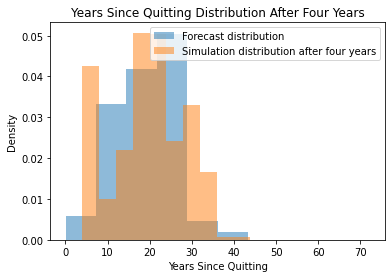

In [12]:
former_smokers = sims.loc[sims.smok_2025 == 'former'].loc[sims.age_group_2025=='60 to 64']

ysq_2025 = (ysq.loc[ysq.sex_id == sex].loc[ysq.year_id == 2025]
             .loc[ysq.location_id == location].loc[ysq.age_group_id=='60 to 64'])
sims_val = pd.DataFrame()
sims_val['2025_ysq'] = np.random.choice(ysq_2025.bin.values,
                                        n_simulants, p=ysq_2025['median'].values / (ysq_2025['median'].sum()))
sims_val['val_2025'] = sims_val['2025_ysq'].str.split(' ', n=2, expand=True)[0].astype(int)
sims_val['val_2025_max'] = sims_val['2025_ysq'].str.split(' ', n=2, expand=True)[2].astype(int)
sims_val['val_2025_uniform'] = np.random.uniform(sims_val.val_2025, sims_val.val_2025_max)

plt.hist(sims_val['val_2025_uniform'], density=True, alpha=0.5)
plt.hist(former_smokers.ysq_2025, density=True, alpha=0.5)
plt.title('Years Since Quitting Distribution After Four Years')
plt.legend(['Forecast distribution','Simulation distribution after four years'])
plt.xlabel('Years Since Quitting')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

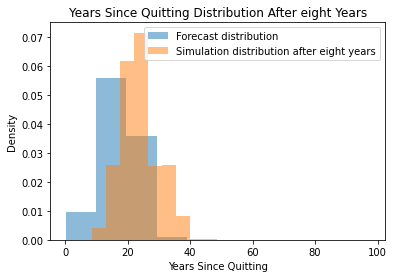

In [9]:
former_smokers = sims.loc[sims.smok_2028 == 'former'].loc[sims.age_group_2028=='55 to 59']

ysq_2028 = (ysq.loc[ysq.sex_id == sex].loc[ysq.year_id == 2028]
             .loc[ysq.location_id == location].loc[ysq.age_group_id=='55 to 59'])
sims_val = pd.DataFrame()
sims_val['2028_ysq'] = np.random.choice(ysq_2028.bin.values,
                                        n_simulants, p=ysq_2028['median'].values / (ysq_2028['median'].sum()))
sims_val['val_2028'] = sims_val['2028_ysq'].str.split(' ', n=2, expand=True)[0].astype(int)
sims_val['val_2028_max'] = sims_val['2028_ysq'].str.split(' ', n=2, expand=True)[2].astype(int)
sims_val['val_2028_uniform'] = np.random.uniform(sims_val.val_2028, sims_val.val_2028_max)

plt.hist(sims_val['val_2028_uniform'], density=True, alpha=0.5)
plt.hist(former_smokers.ysq_2028, density=True, alpha=0.5)
plt.title('Years Since Quitting Distribution After eight Years')
plt.legend(['Forecast distribution','Simulation distribution after eight years'])
plt.xlabel('Years Since Quitting')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

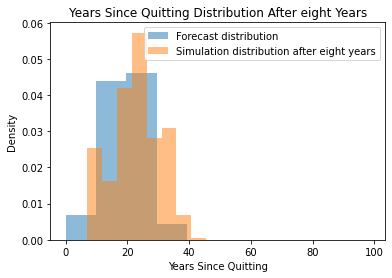

In [10]:
former_smokers = sims.loc[sims.smok_2028 == 'former'].loc[sims.age_group_2028=='60 to 64']

ysq_2028 = (ysq.loc[ysq.sex_id == sex].loc[ysq.year_id == 2028]
             .loc[ysq.location_id == location].loc[ysq.age_group_id=='60 to 64'])
sims_val = pd.DataFrame()
sims_val['2028_ysq'] = np.random.choice(ysq_2028.bin.values,
                                        n_simulants, p=ysq_2028['median'].values / (ysq_2028['median'].sum()))
sims_val['val_2028'] = sims_val['2028_ysq'].str.split(' ', n=2, expand=True)[0].astype(int)
sims_val['val_2028_max'] = sims_val['2028_ysq'].str.split(' ', n=2, expand=True)[2].astype(int)
sims_val['val_2028_uniform'] = np.random.uniform(sims_val.val_2028, sims_val.val_2028_max)

plt.hist(sims_val['val_2028_uniform'], density=True, alpha=0.5)
plt.hist(former_smokers.ysq_2028, density=True, alpha=0.5)
plt.title('Years Since Quitting Distribution After eight Years')
plt.legend(['Forecast distribution','Simulation distribution after eight years'])
plt.xlabel('Years Since Quitting')
plt.ylabel('Density')